Step # 1 : Import required packages

In [1]:
import os
import time
import random
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from helpers import PlotROCCurve
confidence_interval = 95
random_seed = 2023
from helpers import PlotROCCurve

In [2]:
pd.set_option('display.max_columns', 110) 
pd.set_option('display.max_rows', 20) 

Step # 2 : Read input file

In [3]:
df_train = pd.read_csv(r'E:\SMU_Project_Healthcare\ISSS623_Healthcare_Analytics\Modeling\INPUT_DATA_New\train_drop_v3.csv')
df_test= pd.read_csv(r'E:\SMU_Project_Healthcare\ISSS623_Healthcare_Analytics\Modeling\INPUT_DATA_New\test_drop_v3.csv')

In [4]:
df_train.shape

(273032, 109)

In [5]:
df_test.shape

(68258, 109)

In [6]:
# concatenating df_train and df_test along rows
df_master = pd.concat([df_train, df_test], axis=0)

In [7]:
df_master.shape

(341290, 109)

In [8]:
df_master.head()

,intime_ed,outtime_ed,gender,age,outcome_hospitalization,outcome_inhospital_mortality,ed_death,outcome_icu_transfer_12h,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,insurance_Medicaid,insurance_Medicare,insurance_Other,age_group_Young Adults,age_group_Middle-Aged Adults,age_group_Older Adults,age_group_Elderly,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS
0,9/7/2179 12:19,9/7/2179 12:24,1,52.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.08,36.666667,78.0,18.0,99.0,123.0,87.0,6.0,4.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.777778,56.0,16.0,98.0,105.0,66.0,2.0,0.0,0.0,0,0,0,0,1,0,0,99.000000,1,0,2,0,0,1
1,3/17/2138 10:35,3/17/2138 10:41,0,69.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.10,37.055556,65.0,18.0,100.0,149.0,60.0,0.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.722222,58.0,16.0,98.0,143.0,61.0,0.0,0.0,19.0,0,0,0,0,0,1,0,89.666667,8,4,7,0,0,1
2,10/23/2136 14:50,10/23/2136 14:59,1,30.0,0,0,0,0,0,0,0,3,0,0,0,2,0,0,0,0.15,37.000000,82.0,20.0,100.0,160.0,85.0,7.0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,36.888889,66.0,18.0,98.0,127.0,83.0,0.0,1.0,1.0,0,0,0,1,0,0,0,110.000000,1,0,2,0,0,1
3,8/1/2188 2:06,8/1/2188 9:57,1,39.0,1,0,0,0,0,0,0,3,1,0,0,1,0,0,0,7.85,36.111111,78.0,14.0,95.0,127.0,77.0,0.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,36.333333,76.0,18.0,98.0,107.0,54.0,0.0,1.0,2.0,0,0,1,0,1,0,0,93.666667,1,0,0,1,0,0
4,11/12/2143 10:30,11/12/2143 20:41,1,59.0,1,0,0,0,0,0,2,3,0,0,4,4,0,0,0,10.19,36.888889,63.0,18.0,99.0,230.0,87.0,0.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,36.833333,60.0,16.0,97.0,164.0,65.0,0.0,5.0,13.0,0,0,1,0,1,0,0,134.666667,6,4,8,3,3,3


In [9]:
# Understand balance of classes in the given dataframe.
pd.value_counts(df_master['outcome_critical'])

0    326730
1     14560
Name: outcome_critical, dtype: int64

### 2. Variable Selection

In [10]:
variable = ["age", "gender", 
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_temperature", "triage_heartrate", "triage_resprate", 
            "triage_o2sat", "triage_sbp", "triage_dbp", "triage_pain", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache",
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope", 
            "chiefcom_dizziness", 
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", 
            "cci_Pulmonary", "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", 
            "cci_DM2", "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", 
            "cci_Cancer2", "cci_HIV", 
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2", 
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss",
            "eci_Anemia", "eci_Alcohol", "eci_Drugs","eci_Psychoses", "eci_Depression"]

outcome = "outcome_critical"

In [11]:
X = df_master[variable].copy()
y = df_master[outcome].copy()


In [12]:
X.dtypes.to_frame().T

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression
0,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64


In [13]:
encoder = LabelEncoder()
X['gender'] = encoder.fit_transform(X['gender'])


In [14]:
print('class ratio')
ratio = y.sum()/(~y).sum()
print('positive : negative =', ratio, ': 1')

class ratio
positive : negative = -0.04091611634115498 : 1


### 3. Modeling Script

In [15]:
# Containers for all results
result_list = []

### Step 3.1 : Additional Hyper-parameter tuning

#### Let us scale the values using standard scaler and try running the models

In [16]:
pd.set_option('display.max_columns', 110) 
pd.set_option('display.max_rows', 20) 

In [17]:
X.head()

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression
0,52.0,1,0,0,1,0,0,0,0,0,0,36.666667,78.0,18.0,99.0,123.0,87.0,6.0,4.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,69.0,0,0,0,0,0,0,0,0,0,0,37.055556,65.0,18.0,100.0,149.0,60.0,0.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2,30.0,1,0,0,3,0,0,2,0,0,0,37.000000,82.0,20.0,100.0,160.0,85.0,7.0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,39.0,1,0,0,3,0,0,1,0,0,0,36.111111,78.0,14.0,95.0,127.0,77.0,0.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1
4,59.0,1,0,2,3,0,4,4,0,0,0,36.888889,63.0,18.0,99.0,230.0,87.0,0.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0


In [18]:
y

0        0
1        0
2        0
3        0
4        0
        ..
68253    0
68254    0
68255    0
68256    0
68257    0
Name: outcome_critical, Length: 341290, dtype: int64

### Randomforest with hyper-parameter tuning.

In [42]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier


# # Load the dataset (replace with your data)
# X = X_train
# y = y_train

# Split data into train, validation, and test sets
# Remember we use stratify=y to create a balanced, unbiased dataset while splitting into train and test.
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2,stratify=y, random_state=2023)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=2023)

# Create a RandomForestClassifier instance
rf_classifier = RandomForestClassifier()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50,100,200],
    'max_depth': [5,7,10],
    'min_samples_split': [2,4,6],
    'min_samples_leaf': [2,4,6]
}

# Create a GridSearchCV instance
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Perform grid search on the validation data
start = time.time()
grid_search.fit(X_val, y_val)

# Get the best estimator from the grid search
best_rf_model = grid_search.best_estimator_

# Train the best model on the entire train dataset
best_rf_model.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
# Predict on the test data
y_pred = best_rf_model.predict(X_test)

# Evaluate the model's performance on the test set (replace with appropriate metrics)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

Training time: 735.9084539413452 seconds
Test Accuracy: 0.9581880512174397


In [43]:
print(best_rf_model)

RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=6,
                       n_estimators=50)


AUC: 0.8507336376953154
AUPRC: 0.24180784840523142
Sensitivity: 0.8004201680672269
Specificity: 0.7458487508027277
Score thresold: 0.05345900471975601
2.5 97.5


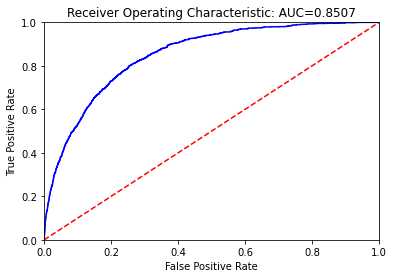

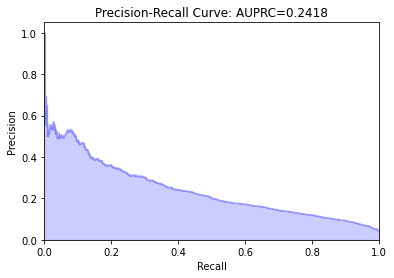

{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 50}


In [44]:
probs = grid_search.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
important_params = grid_search.best_params_
print(important_params)

In [45]:
#!pip install shap

In [46]:
#pip install shap

In [47]:
import shap

In [48]:
explainer = shap.TreeExplainer(best_rf_model)

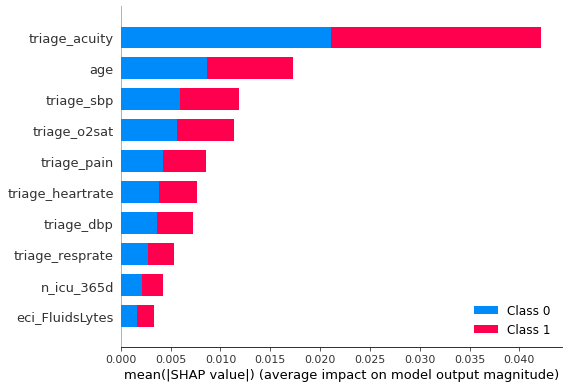

In [49]:
sample = X_test.sample(100)
shap_values = explainer.shap_values(sample)
shap.summary_plot(shap_values,sample,max_display=10)